In [18]:

import sys

import matplotlib.pyplot as plt

#import cv2
import cv2
from deepfly.GUI.os_util import *
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import Axes3D
from deepfly.GUI.CameraNetwork import CameraNetwork
import deepfly.GUI.skeleton as skeleton
import pickle
import glob
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
image_folder = os.path.abspath('./data/test/')
calib = read_calib(image_folder)
num_cameras = skeleton.num_cameras

cid2cidread, cidread2cid = read_camera_order(image_folder)
camNet = CameraNetwork(image_folder=image_folder, num_images=None, cam_id_list=np.arange(num_cameras), calibration=calib, cid2cidread=cid2cidread)

d = pickle.load(open(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0], 'rb'))
for cam in camNet:
    cam.points2d = d["points2d"][cam.cam_id, :]
camNet.triangulate()
pts3d = camNet.points3d_m

Loading predictions ['/home/user/Desktop/deepfly/data/test/preds_-home-user-Desktop-deepfly-data-test.pkl']
Loading heatmaps ['/home/user/Desktop/deepfly/data/test/heatmap_-home-user-Desktop-deepfly-data-test.pkl']
Heatmap shape: (8, 15, 19, 64, 128)
Number of points close to prior epipolar line: 501.0


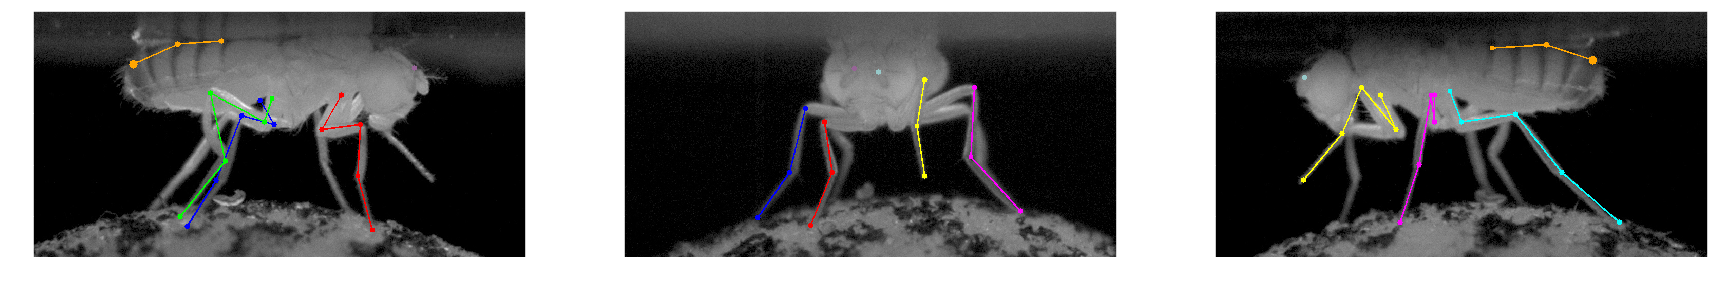

In [15]:
%matplotlib inline
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,30))
ax1.imshow(camNet[1].plot_2d(img_id=0))
ax2.imshow(camNet[3].plot_2d(img_id=0))
ax3.imshow(camNet[5].plot_2d(img_id=0))

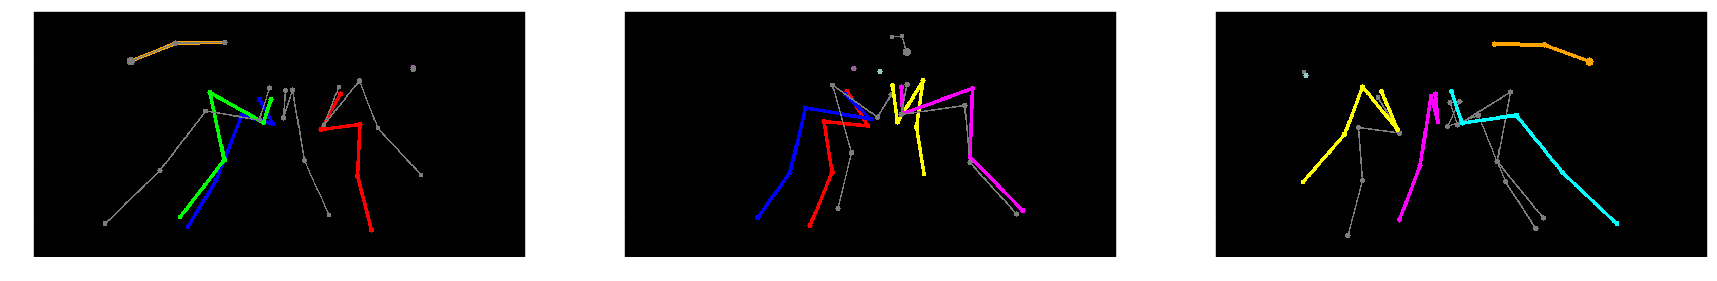

In [16]:
%matplotlib inline
img_id = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,30))
for cam_id, ax in zip([1,3,5], [ax1,ax2,ax3]):
    draw_joints = range(skeleton.num_joints)
    pt = camNet.points3d_m[img_id, :]
    for j in range(skeleton.num_joints):
        if skeleton.is_stripe(j) and skeleton.is_joint_visible_left(j):
            pt[j] = (pt[j] + pt[j+(skeleton.num_joints // 2)]) / 2
            pt[j + skeleton.num_joints // 2] = pt[j]
    pts2d = camNet[cam_id].project(pt)

    thickness = [5]*skeleton.num_limbs
    colors_tmp = skeleton.colors.copy()
    for l in range(skeleton.num_limbs):
        if not skeleton.camera_see_limb(camNet[cam_id].cam_id, l):
            thickness[l] = 2
            colors_tmp[l] = (125,125,125)

    ax.imshow(camNet[cam_id].plot_2d(img=np.ones((480,960,3), dtype=np.uint8), img_id=img_id, pts=pts2d, flip_points=False, colors=colors_tmp, thickness=thickness, draw_joints=draw_joints))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


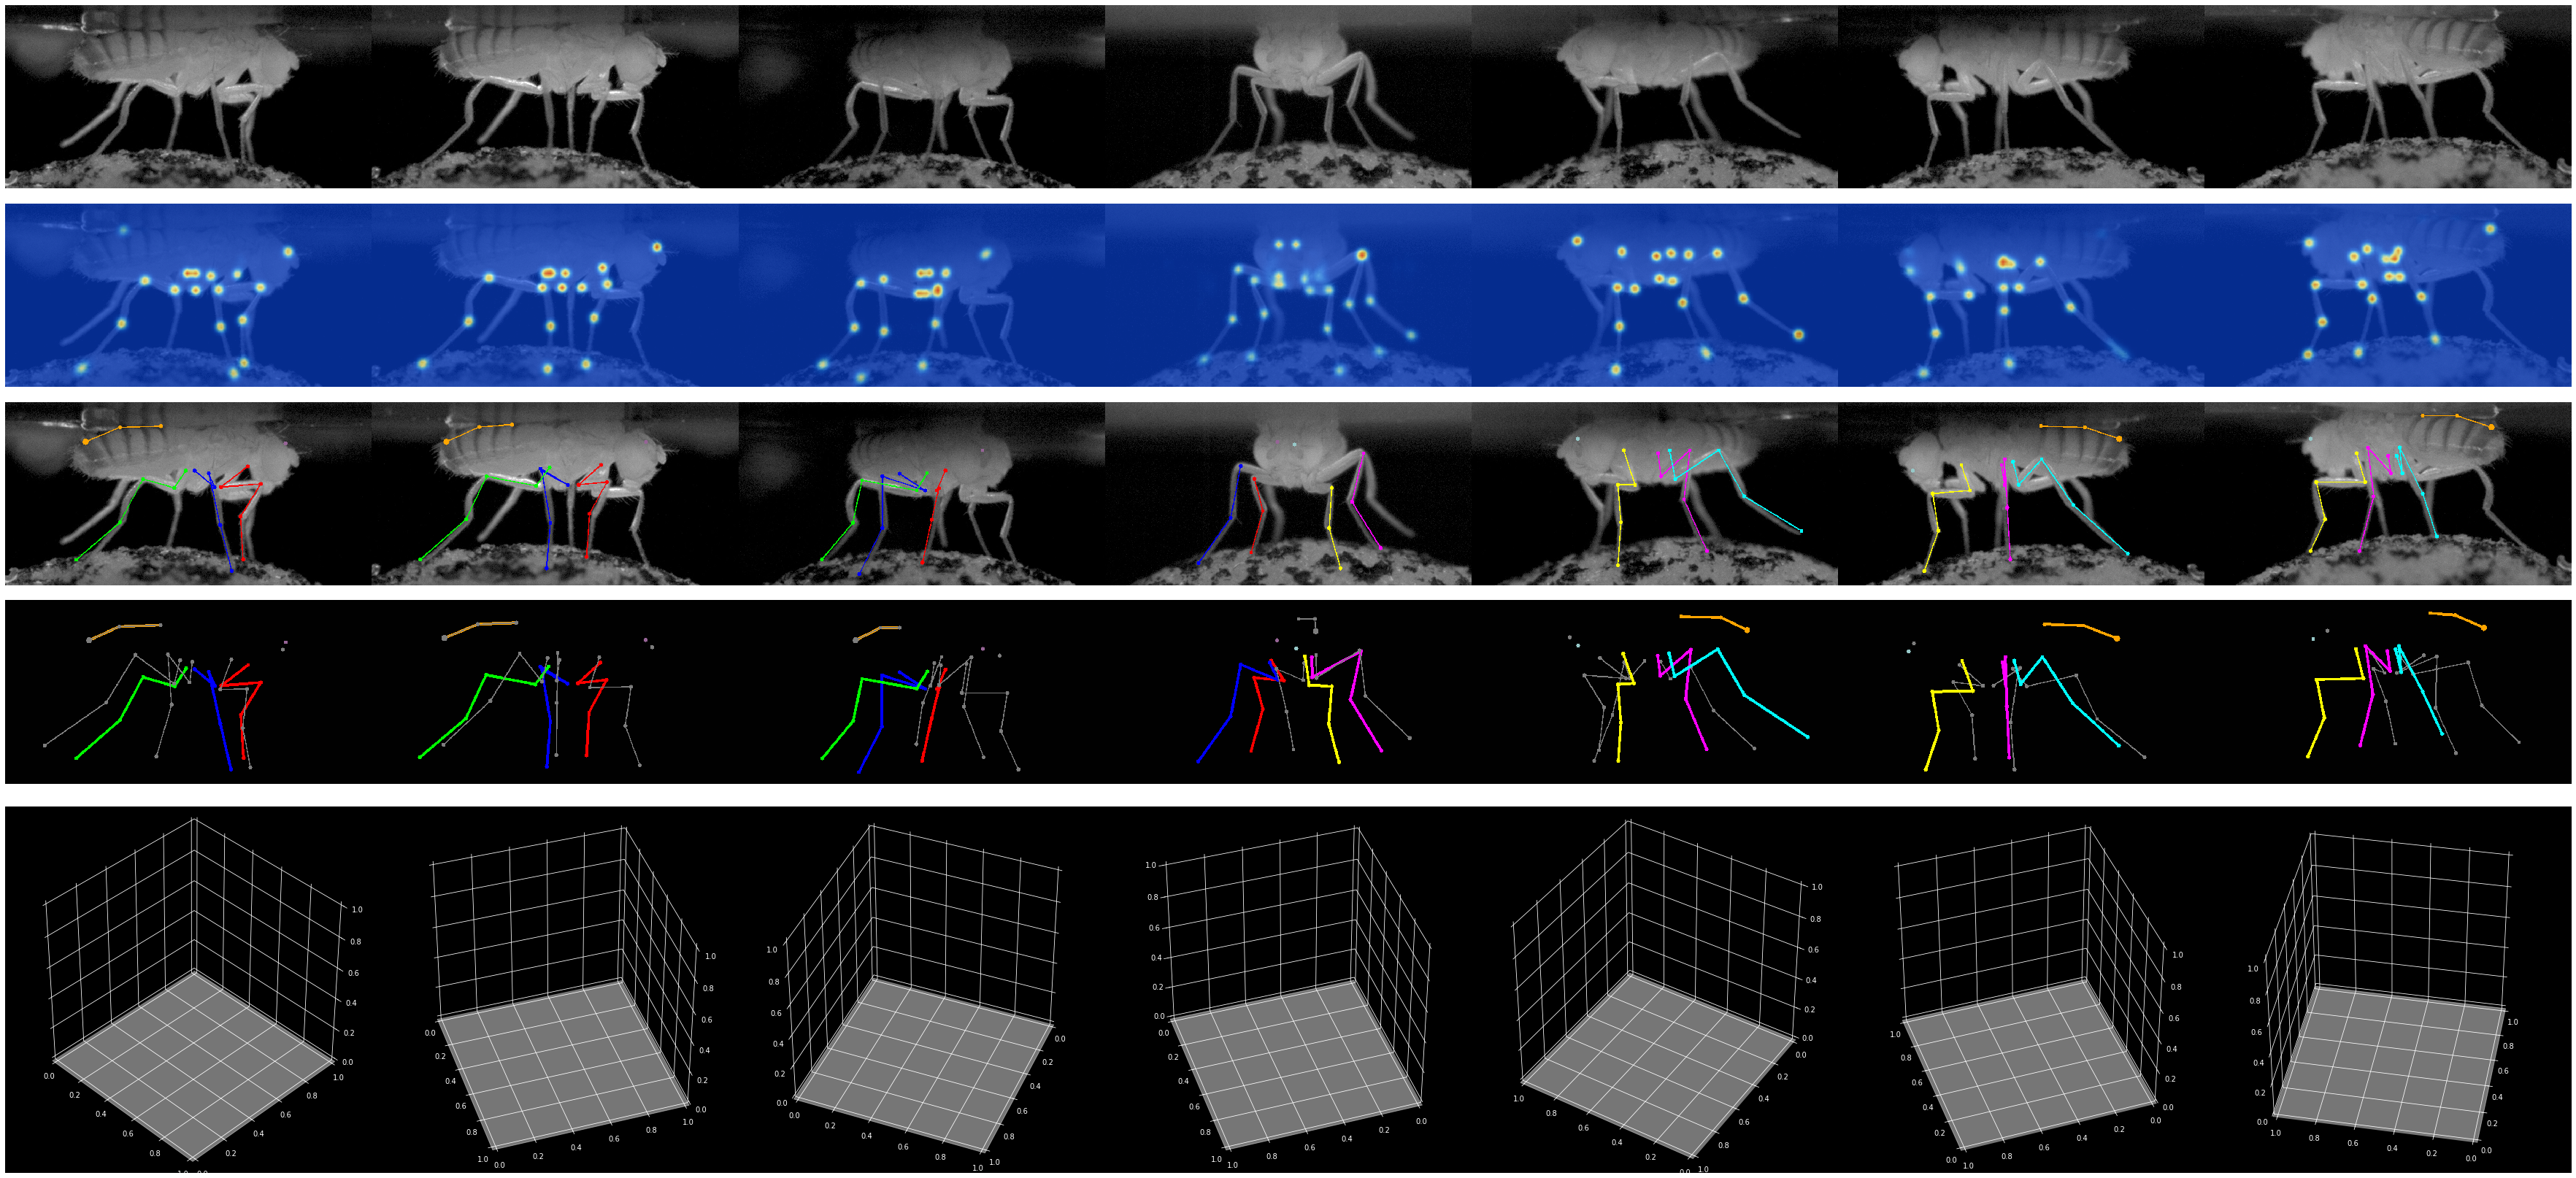

In [37]:
%matplotlib inline
pts3d_filter = pts3d.copy()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from deepfly.GUI.plot_util import plot_drosophila_3d

def normalize_pose_3d(points3d, normalize_length=False, normalize_median=True):
    if normalize_median:
        points3d -= np.median(points3d.reshape(-1, 3), axis=0)
    if normalize_length:
        length = [0.005, 0.01, 0.01, 0.01, 0.01]
        points3d = points3d.reshape(-1, 15, 3)
        for idx in range(points3d.shape[0]):
            for j_idx in range(points3d[idx].shape[0]):
                if j_idx % 5 == 4:  # then tarsus-tip
                    continue
                diff = points3d[idx, j_idx + 1, :] - points3d[idx, j_idx, :]
                diff_norm = (diff / np.linalg.norm(diff)) * length[j_idx % 5]
                points3d[idx, j_idx + 1, :] = points3d[idx, j_idx, :] + diff_norm
                next_tarsus_tip = (j_idx - (j_idx % 5)) + 5
                points3d[idx, j_idx + 2:next_tarsus_tip, :] += (diff_norm - diff)
    return points3d

num_rows, num_cols = 6, 7
fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

plt_list =[]

pts_t = pts3d_filter.copy()
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 

pts_t = normalize_pose_3d(pts_t, normalize_median=True)

for i in range(num_rows*num_cols):
    r = int(i / num_cols)
    c = i % num_cols
    if r==4:
        ax1 = plt.subplot(gs1[r:, c] , projection='3d')
    elif r<4:
        ax1 = plt.subplot(gs1[r,c])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.axis('off')
    if r==4:
        plt_list.append(ax1)
    elif r<4:
        plt_list.append(ax1.imshow(np.zeros((480,960,3), dtype=np.uint8)))

img_id_list = np.arange(15)
for img_id in img_id_list:
    print(img_id)
    for r in range(num_rows):
        #row_image = np.zeros((10,480,3),dtype=np.uint8)
        for c in range(num_cols):
            draw_joints = [j for j in range(skeleton.num_joints) if skeleton.camera_see_joint(c, j)]
            i = r*num_cols + c
            if r == 0: # then raw
                plt_list[i].set_data(camNet[c].get_image(img_id))
            elif r==1: # then heatmap
                plt_list[i].set_data(camNet[c].plot_heatmap(img_id, flip_heatmap=False))
            elif r==2: # then 2d pose
                draw_limbs = None
                plt_list[i].set_data(camNet[c].plot_2d(img_id, flip_points=False, draw_limbs=draw_limbs))
            elif r==3: # then projection of 3d pose
                draw_joints = range(skeleton.num_joints)
                pt = pts3d_filter[img_id,:,:]
                for j in range(skeleton.num_joints):
                    if skeleton.is_stripe(j) and skeleton.is_joint_visible_left(j):
                        pt[j] = (pt[j] + pt[j+(skeleton.num_joints // 2)]) / 2
                        pt[j + skeleton.num_joints // 2] = pt[j]
                pts2d = camNet[c].project(pt)
                
                thickness = [5]*skeleton.num_limbs
                colors_tmp = skeleton.colors.copy()
                for l in range(skeleton.num_limbs):
                    if not skeleton.camera_see_limb(camNet[c].cam_id, l):
                        thickness[l] = 2
                        colors_tmp[l] = (125,125,125)
                        
                plt_list[i].set_data(camNet[c].plot_2d(img=np.ones((480,960,3), dtype=np.uint8), img_id=img_id, pts=pts2d, flip_points=False, colors=colors_tmp, thickness=thickness, draw_joints=draw_joints))
            elif r==4:
                ax_3d = plt_list[i]
                points3d = pts_t[img_id,:,:]
                ang = -90 - (camNet[c].rvec[1]*57.2) + img_id*2
                ax_3d.elev = 40
                draw_joints = [j for j in range(skeleton.num_joints) if (skeleton.is_coxa_femur(j) or skeleton.is_femur_tibia(j) or skeleton.is_tibia_tarsus(j) or skeleton.is_tarsus_tip(j) or skeleton.is_stripe(j))]
                
                plot_drosophila_3d(ax_3d=ax_3d, points3d=points3d, cam_id=c, ang=ang, draw_joints=draw_joints)
    #plt.show()
    
    fig.savefig('/home/user/Desktop/tmp/{}.jpg'.format(img_id))
    for c in range(num_cols):
        if num_rows >= 4:
            r = 4
            i = r*num_cols + c
            ax_3d = plt_list[i]
            ax_3d.cla()
        